# Portfolio Analysis Problem Set: Question 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats

In [2]:
df = pd.read_csv('2008_data.csv', index_col=0)
securities = df.loc[:, 'Agric':'Other']
market = df.loc[:, 'SP500']
interest = df.loc[:, 'LIBOR']

## Part (a)

In [3]:
mu = securities.mean()
cov = securities.cov()

## Part (b)

There is fairly good agreement with theory here: all the hyperbola segments appear to lie within the envelope of another, larger hyperbola (the Markowitz bullet). Of course, since we are only plotting the no-short-selling portions of the frontier, it may be hard to see, since they all lie in the upper arm of the bullet.

This is fairly consistent across years: 2003, 2004, all exhibit this phenomenon.

In [4]:
# Naive portfolio
naive = securities.mean(axis=1)
mu_naive = naive.mean()
sigma_naive = naive.std()

In [5]:
# Market portfolio
mu_market = market.mean()
sigma_market = market.std()

In [6]:
# Minimum variance portfolio
sigma_mvp = 1 / np.linalg.inv(cov).sum()
weights_mvp = sigma_mvp**2 * np.linalg.inv(cov) @ np.ones(cov.shape[0])
mu_mvp = mu @ weights_mvp

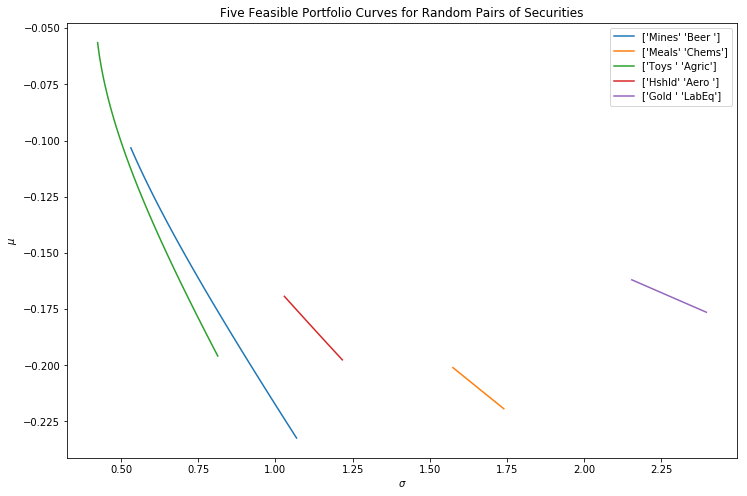

In [7]:
# Plot feasible portfolio curves for 5 random pairs of securities
mu_list = []
sigma_list = []
choices_list = []
for _ in range(5):
    choices = np.random.choice(securities.columns, 2, replace=False)

    mus = securities[choices].mean()
    sigmas = securities[choices].std()
    rho, _ = stats.pearsonr(securities[choices[0]], securities[choices[1]])
    A_sq = np.sqrt((sigmas[0]**2 + sigmas[1]**2 - 2*rho*sigmas[0]*sigmas[1]) / (mus[0] - mus[1]) ** 2)
    
    mu_v = np.linspace(mus.min(), mus.max())
    sigma_v = np.sqrt(sigma_mvp**2 + A_sq * (mu_v - mu_mvp)**2)

    mu_list.append(mu_v)
    sigma_list.append(sigma_v)
    choices_list.append(str(choices))

plt.figure(figsize=[12, 8])
for mu_v, sigma_v in zip(mu_list, sigma_list):
    plt.plot(sigma_v, mu_v)

plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('Five Feasible Portfolio Curves for Random Pairs of Securities')
plt.legend(choices_list);

## Part (c)

Depending on the year, the upper half of the hyperbola (i.e. the efficient frontier) may appear very straight. 2003 and 2004 have curves so straight they look linear, whereas 

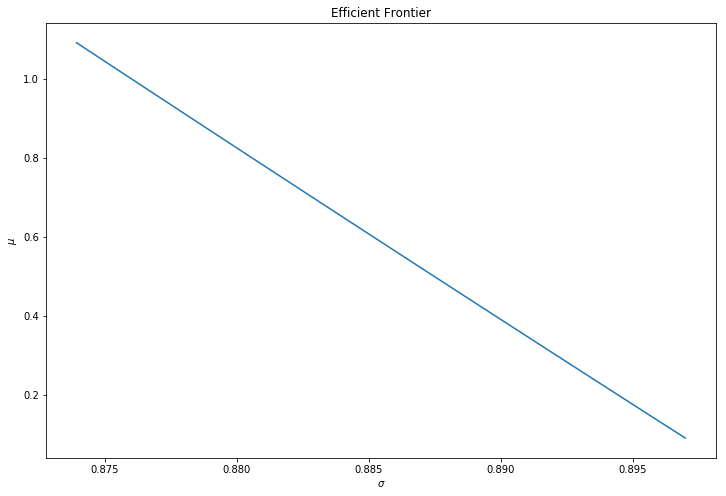

In [8]:
# Compute and graph efficient frontier
m_tilde = np.vstack([mu, np.ones(mu.shape)]).T
B = m_tilde.T @ np.linalg.inv(cov) @ m_tilde
G = np.linalg.inv(B) @ m_tilde.T @ np.linalg.inv(cov) @ m_tilde @ np.linalg.inv(B)
a, d, _, b = G.flatten()

mu_mvp = d / a
sigma_mvp = np.sqrt(np.linalg.det(G) / a)

mus = np.linspace(mu_mvp, mu_mvp + 1)  # A bit of kludge here...
sigmas = np.sqrt(a*(mu_v - d/a)**2 + (1/a)*np.linalg.det(G))

plt.figure(figsize=[12, 8])
plt.plot(sigmas, mus)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('Efficient Frontier');

## Part (d)

In almost all cases (e.g. 2003, 2004), increasing mus imply increasing sigmas, thanks to the agreement with theory in part (b). Furthermore, in almost all cases (the same years as above), $w_2$ is found to be a convex combination of $w_1$ and $w_3$. This means that efficient portfolios all lie in a line segment in $w$-space, in accordance with the theory.

2008 is an outlier. In 2008, increasing mus do not imply increasing sigmas, but it is still the case that $w_2$ is a convex combination of $w_1$ and $w_3$. One can only assume that the financial crash ruined many of the assumptions of Markowitz theory (e.g. no arbitrage, for instance), which ruins any theoretical guarantees.

In [9]:
choices = np.random.choice(mu_v.shape[0], 3, replace=False)

# Find indices that sort the chosen mu_v's
indices = np.argsort(mu_v[choices])

# Check if the sorted sigma_v's are increasing (i.e. positive differences)
increasing = (np.diff(sigma_v[choices][indices]) > 0).all()

msg = 'Increasing mus imply increasing sigmas.' if increasing else 'Increasing mus do NOT imply increasing sigmas!'
print(msg)

Increasing mus do NOT imply increasing sigmas!


In [10]:
def mu_to_weights(mu):
    mu_tilde = np.vstack([mu, 1])
    return (np.linalg.inv(cov) @ m_tilde @ np.linalg.inv(B) @ mu_tilde).flatten()


mu1, mu2, mu3 = mu_v[choices]
sigma1, sigma2, sigma3 = sigma_v[choices][indices]  # For part (g)

w1 = mu_to_weights(mu1)
w2 = mu_to_weights(mu2)
w3 = mu_to_weights(mu3)

In [11]:
# For the first security, solve the equation alpha*w1 + (1-alpha)*w3 = w2
# This alpha should work for all securities.
alpha = (w2[0] - w3[0]) / (w1[0] - w3[0])

is_combo = np.allclose(alpha*w1 + (1-alpha)*w3, w2)
msg = 'w2 is a convex combination of w1 and w3.' if is_combo else 'w2 is NOT a convex combination of w1 and w3!'
print(msg)

w2 is a convex combination of w1 and w3.


## Part (e)

Interestingly, in almost all cases (e.g. 2003, 2004), the risk-free rate is _higher_ than the mean minimum variance portfolio returns. This disagreement with theory cascades down: the capital market line does not make sense (it has a negative slope, and is no longer tangent to the Markowitz bullet).

In [12]:
R = interest.mean()

msg = 'R < mu_mvp.' if R < mu_mvp else 'R is NOT < mu_mvp!'
print(msg)

R is NOT < mu_mvp!


## Part (f)

While we can plug our variables into the formula for the capital market line, the line does not make sense (and, depending on how you think about it, doesn't even exist). If $ R < \mu_{MVP} $, then the capital market line does not have a positive slope (which is nonsensical, since you would never take on more risk to _lower_ your expected return), and it also does not lie tangent to the Markowitz bullet (instead, it intersects it, cutting through the interior of the bullet).

In [13]:
R = interest.mean()
mu_M = market.mean()
sigma_M = market.std()

sigmas = np.linspace(0, 1)
mus = R + ((mu_M - R) / sigma_M) * sigmas  # Capital Market Line

## Part (g)

For the year 2003, the betas versus mus appear to lie fairly close to a line. However, for 2004, they do not.

In [14]:
def weights_to_beta(weights):
    returns_portfolio = (weights * securities).sum(axis=1)
    # np.cov returns cov matrix; get the diagonal element
    cov = np.cov(returns_portfolio, market)[0, 1]
    beta = cov / sigma_M**2
    return beta, returns_portfolio  # Return portfolio returns for part (h)

In [15]:
beta_mvp, returns_mvp = weights_to_beta(weights_mvp)
beta1, returns1 = weights_to_beta(w1)
beta2, returns2 = weights_to_beta(w2)
beta3, returns3 = weights_to_beta(w3)
beta_naive, returns_naive = weights_to_beta(np.ones(48) / 48)

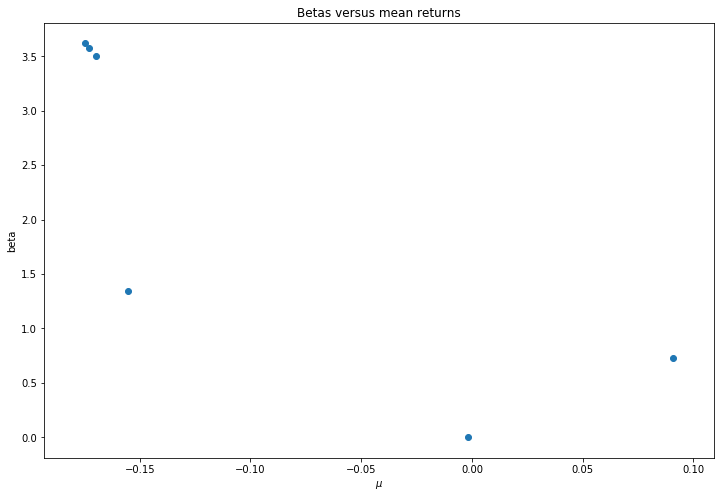

In [16]:
fig = plt.figure(figsize=[12, 8])
mus = [mu_M, mu_mvp, mu1, mu2, mu3, mu_naive]
betas = [0, beta_mvp, beta1, beta2, beta3, beta_naive]
plt.scatter(mus, betas)
plt.title('Betas versus mean returns')
plt.xlabel('$\mu$')
plt.ylabel('beta');

## Part (h)

Depending on the year, and your luck with the randomly chosen portfolios, these equity curves may seem very unreasonable. Oddly enough, for a few years (e.g. 2004), the naive portfolio fluctuates wildly, achieving returns as much as 250% and as low as -100%. This may be due to a data error.

In [17]:
equity_market = (1+market).cumprod()
equity_naive = (1+returns_naive).cumprod()
equity_mvp = (1+returns_mvp).cumprod()

equity1 = (1+returns1).cumprod()
equity2 = (1+returns2).cumprod()
equity3 = (1+returns3).cumprod()

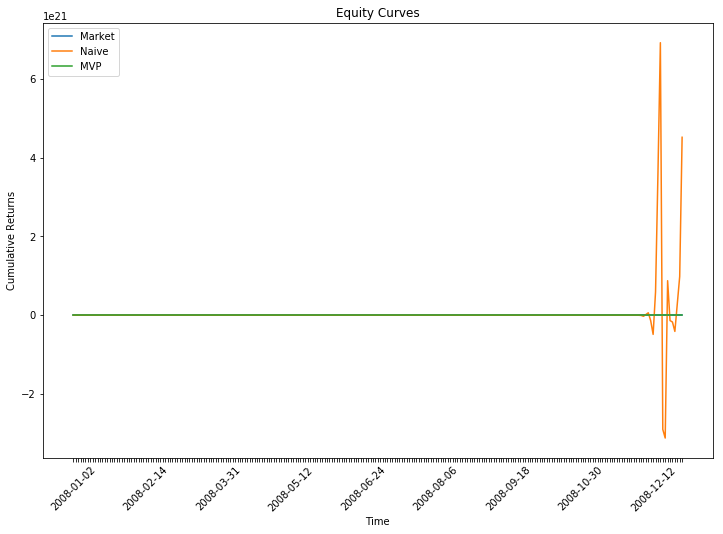

In [18]:
fig = plt.figure(figsize=[12, 8])

plt.plot(equity_market, label='Market')
plt.plot(equity_naive, label='Naive')
plt.plot(equity_mvp, label='MVP')
#plt.plot(equity1, label='Portfolio 1')
#plt.plot(equity2, label='Portfolio 2')
#plt.plot(equity3, label='Portfolio 3')

# Ugly hack to only show one x tick for every 30 days
for index, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
    if index % 30 != 0:
        label.set_visible(False)
    
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Equity Curves')
plt.xticks(rotation=45)
plt.legend();